In [76]:
# load in packages
from itertools import combinations

from test_results import valid_results, test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
train = pd.read_csv('starbucks_train.txt', index_col=0)

In [55]:
test = pd.read_csv('starbucks_test.txt', index_col=0)

In [15]:
import pandas as pd
import numpy as np

def score(df, promo_pred_col = 'Promotion'):
    n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)
    

def test_results(promotion_strategy):
    test_data = pd.read_csv('starbucks_test.txt')
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    print("Nice job!  See how well your strategy worked on our test data below!")
    print()
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    
    print("We came up with a model with an irr of {} and an nir of {} on the test set.\n\n How did you do?".format(0.0188, 189.45))
    return irr, nir

# added this function to test our irr and nlr on the validation set
def valid_results(promotion_strategy, valid_data):
    df = valid_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    print("Nice job!  See how well your strategy worked on our valid data below!")
    print()
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    
    print("We came up with a model with an irr of {} and an nir of {} on the test set.\n\n How did you do?".format(0.0188, 189.45))
    return irr, nir

In [19]:
# testing baseline model, where we send promotions to everyone

def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [22]:
train

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
ID,,,,,,,,,
1,No,0,2,30.443518,-1.165083,1,1,3,2
3,No,0,3,32.159350,-0.645617,2,3,2,2
4,No,0,2,30.431659,0.133583,1,1,4,2
5,No,0,0,26.588914,-0.212728,2,1,4,2
8,Yes,0,3,28.044332,-0.385883,1,1,2,2
...,...,...,...,...,...,...,...,...,...
126180,No,0,1,30.084876,1.345672,1,1,3,1
126181,Yes,0,3,33.501485,-0.299306,1,1,4,1
126182,No,0,1,31.492019,1.085939,2,3,2,2


In [140]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

def custom_profit_loss(y_true, y_pred, targeted):
    residual = (y_true - y_pred).astype("float")
    expected_gain = (10-5)*residual - (10)*residual
    loss = np.log(1 + np.exp(-2*expected_gain*residual))
    grad = (1 + np.exp(-2*expected_gain*residual))**-1
    hess = -np.exp(-2*expected_gain*residual)*(1 + np.exp(-2*expected_gain*residual))**-2 
    return grad, hess
    

Text(0, 0.5, 'first or second derivates')

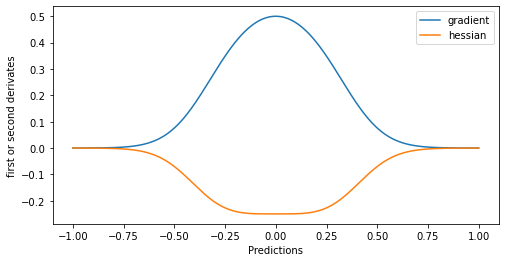

In [141]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
y_true = np.repeat(0,1000)
y_pred = np.linspace(-1,1,1000)
# ax.plot(y_hat, errors)
grad, hess = custom_profit_loss(y_true, y_pred)
ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

In [94]:
3.75/2

1.875

In [31]:
response = []

for index, row in train.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train['response'] = response

In [43]:
train.loc[train['Promotion'] == False, 'Promotion'] = int(0)
train.loc[train['Promotion'] == True, 'Promotion'] = int(1)


In [59]:
test.loc[test['Promotion'] == "No", 'Promotion'] = 0
test.loc[test['Promotion'] == "Yes", 'Promotion'] = 1

In [50]:
train['Promotion'] = train['Promotion'].astype(int)

In [62]:
test['Promotion'] = test['Promotion'].astype(int)

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27699 entries, 52143 to 63562
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Promotion  27699 non-null  int32  
 1   purchase   27699 non-null  int64  
 2   V1         27699 non-null  int64  
 3   V2         27699 non-null  float64
 4   V3         27699 non-null  float64
 5   V4         27699 non-null  int64  
 6   V5         27699 non-null  int64  
 7   V6         27699 non-null  int64  
 8   V7         27699 non-null  int64  
 9   response   27699 non-null  float64
dtypes: float64(3), int32(1), int64(6)
memory usage: 2.2 MB


In [78]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

train, valid = sk.model_selection.train_test_split(train, test_size=0.2,random_state=42)
# generate features and labels
y_train = train['response']
X_train = train[features]

y_valid = valid['response']
X_valid = valid[features]

eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [142]:
# make new model on new value
gbm3 = lgbm.LGBMClassifier(random_state=33,
                          learning_rate=.05,
                          max_depth=100,
                          silent=True)
gbm3.set_params(**{'objective': custom_profit_loss}, 
               metrics = ['mse'])

gbm3.fit(
    X_train, y_train, eval_set=eval_set, verbose=True
)

[1]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[2]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[3]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[4]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[5]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[6]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[7]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[8]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[9]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[10]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[11]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[12]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[13]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[14]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[15]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[16]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[17]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[18]	valid_0's l2: 0.00821337	valid_1's l2: 0.00830325
[19]	valid_0's l2: 

LGBMClassifier(learning_rate=0.05, max_depth=100, metrics=['mse'],
               objective=<function custom_profit_loss at 0x000002741CCCEAE8>,
               random_state=33)

In [21]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

In [63]:
gbm3.predict(test)

array([0., 0., 0., ..., 1., 0., 0.])